# Exploratory Data Analysis (EDA)

In [2]:
!pip install openTSNE

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif , SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import os

current_path = os.getcwd()

In [4]:
data_path = os.path.join(current_path, "data", "phase2", "train.csv")
df = pd.read_csv(data_path)
df = pl.from_pandas(df)

In [5]:
"""
Id: Unique identifier for each row in the test set.
flow_time: Duration of network flow.
header_size: Size of the packet headers.
packet_duration: Duration of individual packets.
overall_rate: Overall data transfer rate.
src_rate: Data transfer rate from the source.
dst_rate: Data transfer rate towards the destination.
fin_packets: Number of packets flagged as finished (FIN).
urg_packets: Number of urgent packets (URG).
rst_packets: Number of reset packets (RST).
max_value: Maximum value observed in packet data.
syn_flags: Number of SYN (synchronize) flags detected.
rst_flags: Number of RST (reset) flags detected.
psh_flags: Number of PSH (push) flags detected.
ack_flags: Number of ACK (acknowledge) flags detected.
protocol_http: Indicates HTTP protocol usage.
protocol_https: Indicates HTTPS protocol usage.
protocol_tcp: Indicates TCP protocol usage.
protocol_udp: Indicates UDP protocol usage.
protocol_icmp: Indicates ICMP protocol usage.
label (only in train.csv): Type of cyber-attack to be predicted (e.g., DDoS, DoS, benign).
"""
df.schema

Schema([('flow_time', Float64),
        ('header_size', Float64),
        ('packet_duration', Float64),
        ('overall_rate', Float64),
        ('src_rate', Float64),
        ('dst_rate', Float64),
        ('fin_packets', Float64),
        ('urg_packets', Float64),
        ('rst_packets', Float64),
        ('max_value', Float64),
        ('value_covariance', Float64),
        ('fin_flags', Int64),
        ('syn_flags', Int64),
        ('rst_flags', Int64),
        ('psh_flags', Int64),
        ('ack_flags', Int64),
        ('protocol_http', Int64),
        ('protocol_https', Int64),
        ('protocol_tcp', Int64),
        ('protocol_udp', Int64),
        ('protocol_icmp', Int64),
        ('label', String)])

In [6]:
df.describe()

shape: (9, 23)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic ‚îÜ flow_time ‚îÜ header_si ‚îÜ packet_du ‚îÜ ‚Ä¶ ‚îÜ protocol_ ‚îÜ protocol_ ‚îÜ protocol_ ‚îÜ label    ‚îÇ
‚îÇ ---       ‚îÜ ---       ‚îÜ ze        ‚îÜ ration    ‚îÜ   ‚îÜ tcp       ‚îÜ udp       ‚îÜ icmp      ‚îÜ ---      ‚îÇ
‚îÇ str       ‚îÜ f64       ‚îÜ ---       ‚îÜ ---       ‚îÜ   ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ str      ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ f64       ‚îÜ f64       ‚îÜ   ‚îÜ f64       ‚îÜ f64       ‚îÜ f64       ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count     ‚îÜ 938583.0  ‚îÜ 938583.0  ‚îÜ 938583.0  ‚îÜ ‚Ä¶ ‚îÜ 938583.0  ‚îÜ 938583.0  ‚îÜ 938583.0  ‚îÜ 938583   ‚îÇ
‚îÇ null_coun ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ ‚Ä¶ ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ 0        ‚îÇ
‚îÇ t         ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ mean      ‚îÜ 13.42515  ‚îÜ 101813.42 ‚îÜ 82.664589 ‚îÜ ‚Ä¶ ‚îÜ 0.574175  ‚îÜ 0.21141   ‚îÜ 0.164314  ‚îÜ null     ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ 3375      ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ std       ‚îÜ 5898.0987 ‚îÜ 1.8014e6  ‚îÜ 166.98632 ‚îÜ ‚Ä¶ ‚îÜ 0.494468  ‚îÜ 0.408309  ‚îÜ 0.37056   ‚îÜ null     ‚îÇ
‚îÇ           ‚îÜ 33        ‚îÜ           ‚îÜ 5         ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ min       ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ ‚Ä¶ ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ BenignTr ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ affic    ‚îÇ
‚îÇ 25%       ‚îÜ 0.0       ‚îÜ 54.0      ‚îÜ 64.0      ‚îÜ ‚Ä¶ ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ null     ‚îÇ
‚îÇ 50%       ‚îÜ 0.0       ‚îÜ 54.0      ‚îÜ 64.0      ‚îÜ ‚Ä¶ ‚îÜ 1.0       ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ null     ‚îÇ
‚îÇ 75%       ‚îÜ 0.101755  ‚îÜ 364.0     ‚îÜ 64.0      ‚îÜ ‚Ä¶ ‚îÜ 1.0       ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ null     ‚îÇ
‚îÇ max       ‚îÜ 4.9301e6  ‚îÜ 3.3111737 ‚îÜ 6525.74   ‚îÜ ‚Ä¶ ‚îÜ 1.0       ‚îÜ 1.0       ‚îÜ 1.0       ‚îÜ Recon    ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ e8        ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [7]:
# how may classes do we have?
print(df["label"].unique().value_counts().sum()["count"][0] ," unique labels")
df = df.with_columns(pl.col("label").str.to_lowercase()) # case folding , expression object: pl.col("label")

# Are the classes unbalanced
quickOVERVIEW = df["label"].value_counts().with_columns((pl.col("count")/df["label"].shape[0] *100).alias("percentage"))
quickOVERVIEW

6  unique labels


shape: (6, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ label         ‚îÜ count  ‚îÜ percentage ‚îÇ
‚îÇ ---           ‚îÜ ---    ‚îÜ ---        ‚îÇ
‚îÇ str           ‚îÜ u32    ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ dos           ‚îÜ 163428 ‚îÜ 17.412205  ‚îÇ
‚îÇ benigntraffic ‚îÜ 21987  ‚îÜ 2.342574   ‚îÇ
‚îÇ ddos          ‚îÜ 687027 ‚îÜ 73.198321  ‚îÇ
‚îÇ recon         ‚îÜ 6433   ‚îÜ 0.685395   ‚îÇ
‚îÇ mirai         ‚îÜ 53395  ‚îÜ 5.688895   ‚îÇ
‚îÇ mitm          ‚îÜ 6313   ‚îÜ 0.67261    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

<BarContainer object of 6 artists>

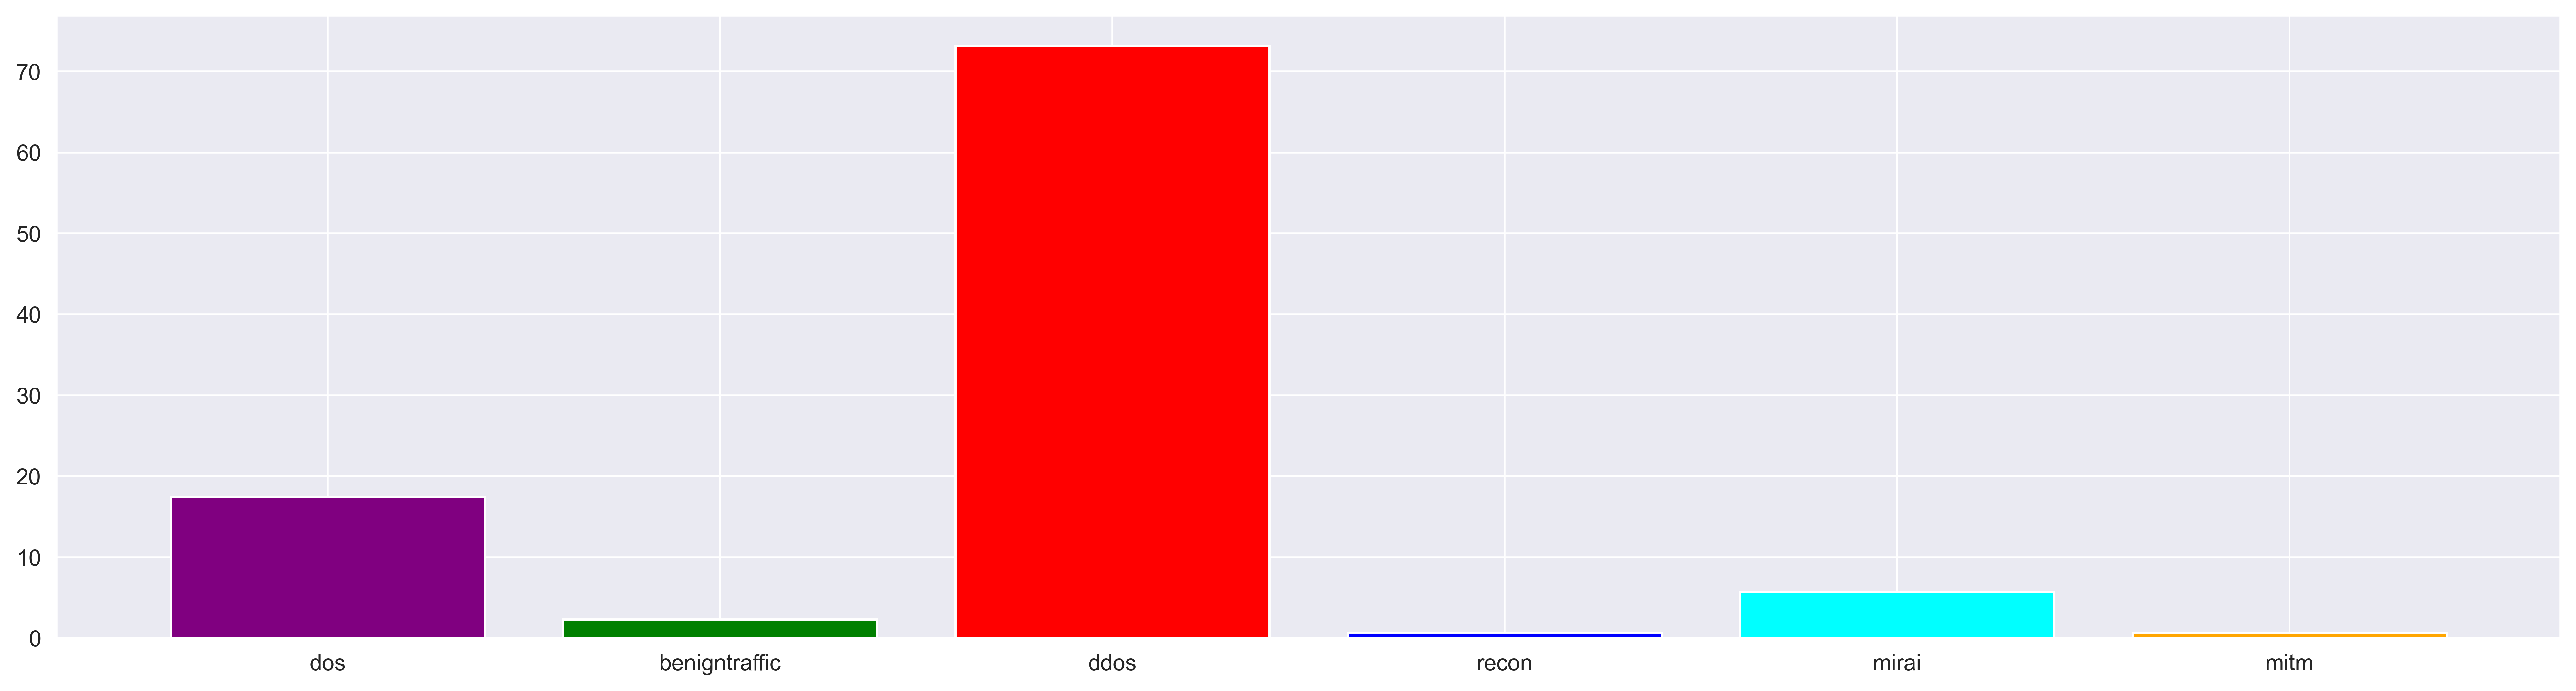

In [8]:
plt.figure(figsize=(20, 5), dpi=500)
plt.bar(
    quickOVERVIEW["label"], 
    height=quickOVERVIEW["percentage"] , 
    color= quickOVERVIEW["label"].replace({
    "ddos": "red",             
    "recon": "blue",           
    "benigntraffic": "green", 
    "mitm": "orange",          
    "dos": "purple",          
    "mirai": "cyan"           
}
))

In [10]:
profile = ProfileReport(df.to_pandas(), title="Profiling Report" , explorative=True , lazy= True , minimal = True)
# Display the report (Kaggle should automatically render it)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 22/22 [00:02<00:00,  8.92it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

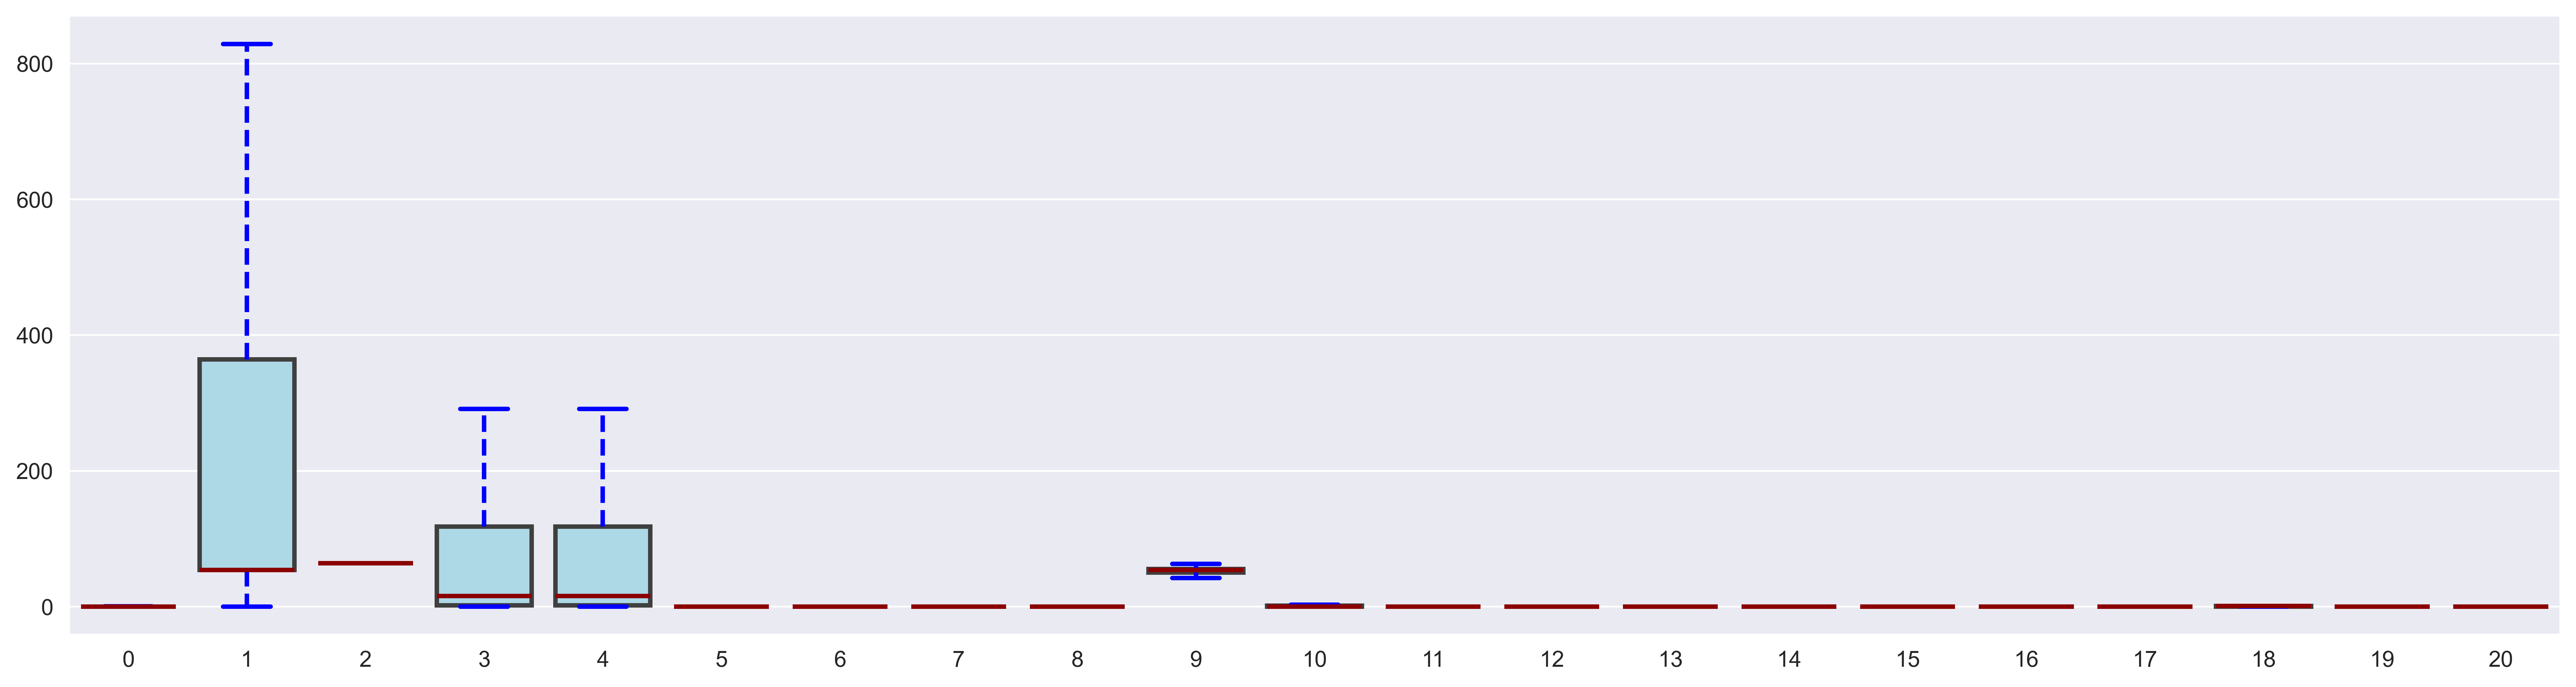

In [9]:
plt.figure(figsize=(20, 5), dpi=500)

sns.boxplot(
    data=df.select(cs.numeric()),#numeric columns only
    showfliers=False,  # hide extreme outliers
    boxprops=dict(facecolor="lightblue", linewidth=2),  # box styling
    whiskerprops=dict(color="blue", linewidth=2, linestyle="--"),
    medianprops=dict(color="darkred", linewidth=2),
    capprops=dict(color="blue", linewidth=2),
    # gap=1.5
)

plt.show()

In [10]:
df[[col for i, col in enumerate(df.columns) if i in [1, 3, 4, 9]]].describe()

shape: (9, 5)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ header_size   ‚îÜ overall_rate  ‚îÜ src_rate      ‚îÜ max_value  ‚îÇ
‚îÇ ---        ‚îÜ ---           ‚îÜ ---           ‚îÜ ---           ‚îÜ ---        ‚îÇ
‚îÇ str        ‚îÜ f64           ‚îÜ f64           ‚îÜ f64           ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 938583.0      ‚îÜ 938583.0      ‚îÜ 938583.0      ‚îÜ 938583.0   ‚îÇ
‚îÇ null_count ‚îÜ 0.0           ‚îÜ 0.0           ‚îÜ 0.0           ‚îÜ 0.0        ‚îÇ
‚îÇ mean       ‚îÜ 101813.423375 ‚îÜ 9163.49561    ‚îÜ 9163.49561    ‚îÜ 177.16136  ‚îÇ
‚îÇ std        ‚îÜ 1.8014e6      ‚îÜ 100180.600226 ‚îÜ 100180.600226 ‚îÜ 515.425327 ‚îÇ
‚îÇ min        ‚îÜ 0.0           ‚îÜ 0.0           ‚îÜ 0.0           ‚îÜ 42.0       ‚îÇ
‚îÇ 25%        ‚îÜ 54.0          ‚îÜ 2.077074      ‚îÜ 2.077074      ‚îÜ 50.0       ‚îÇ
‚îÇ 50%        ‚îÜ 54.0          ‚îÜ 15.703769     ‚îÜ 15.703769     ‚îÜ 54.0       ‚îÇ
‚îÇ 75%        ‚îÜ 364.0         ‚îÜ 117.774989    ‚îÜ 117.774989    ‚îÜ 55.14      ‚îÇ
‚îÇ max        ‚îÜ 3.3111737e8   ‚îÜ 7.340032e6    ‚îÜ 7.340032e6    ‚îÜ 30329.2    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [11]:
ScaledFeatures =  StandardScaler().fit_transform(df.select(cs.numeric()))
df = pl.concat(items = [pl.DataFrame(ScaledFeatures , schema = df.select(cs.numeric()).columns) , df.select("label")] ,  how="horizontal")

In [12]:
#feature selection 
selector = SelectKBest(score_func=f_classif, k=10)

selector.fit(df.select(cs.numeric()), df["label"])

selected_indices = selector.get_support(indices=True)
print(selected_indices , len(selected_indices),"features")
selected_features = [df.select(cs.numeric()).columns[i] for i in selected_indices]
print("\nSelected features: \n", selected_features)

[ 7  8  9 10 11 15 17 18 19 20] 10 features

Selected features: 
 ['urg_packets', 'rst_packets', 'max_value', 'value_covariance', 'fin_flags', 'ack_flags', 'protocol_https', 'protocol_tcp', 'protocol_udp', 'protocol_icmp']


In [13]:
# not as we did in phase 1 , we will be testing undersampling and oversampling, 
# validated my idea by generative pre-trained transformers

"""You're dealing with a pretty classic **class imbalance problem**, especially with `"ddos"` being massively overrepresented and `"benigntraffic"`, `"mitm"`, and `"recon"` heavily underrepresented.

Here's a breakdown of your idea, and some suggestions:

---

### ‚úÖ Your Plan (Under + Over Sampling):
Using **undersampling on the majority ("ddos")** and then **oversampling the minority classes** is totally reasonable and commonly done. Here's how it might work:

#### Step-by-step version of your plan:
1. **Undersample "ddos"** to reduce its impact.
2. **Oversample "benigntraffic", "mitm", "recon"**, and maybe even "mirai" to get a more balanced dataset.
3. **Possibly leave "dos" as is**, or slightly adjust it.

---

### üß† Tips on Executing It:

#### 1. ‚öñÔ∏è **Target Balance Strategy**
Decide your final desired sample size per class. Example ideas:
- Match to the size of "mirai" (~50K)
- Or go a bit lower to reduce training size, say ~30K per class
- Avoid exact balance ‚Äî slight randomness can help generalization

#### 2. üßπ **Undersampling "ddos"**
You can randomly select ~30K‚Äì50K rows from "ddos" (from 687K). Make sure to **shuffle** before picking.

#### 3. üîÅ **Oversampling Minorities**
Use techniques like:
- **Random Oversampling** (e.g., simple duplication)
- **SMOTE/ADASYN** (synthetic data generation, if the features support it ‚Äî i.e., numeric and continuous)

> Note: SMOTE doesn‚Äôt work well with categorical data unless encoded carefully.

#### 4. üß™ **Be Careful with Oversampling**
If you're evaluating on the same dataset, make sure not to **leak duplicated synthetic samples into your validation set** ‚Äî only oversample in the training split.

---

### ‚öñÔ∏è Alternative: Use Class Weights
If you're using tree-based models (like XGBoost, LightGBM) or neural nets, consider using **class weighting** instead. It avoids changing the actual data and simply adjusts the cost of misclassification.

---

### üëÄ Example Target Distribution
| Label          | Target Count |
|----------------|--------------|
| ddos           | 30,000       |
| benigntraffic  | 30,000       |
| mitm           | 30,000       |
| mirai          | 30,000       |
| recon          | 30,000       |
| dos            | 30,000       |

You could tune this depending on whether you want full balance or slight realism.

---

### üì¶ TL;DR
- Your under+over strategy is solid.
- Make sure not to leak synthetic samples into validation/test.
- Consider class weights as a simpler alternative if supported.
- Don‚Äôt overdo oversampling ‚Äî can lead to overfitting if minority class is too tiny.

Would you like help with writing some code to implement this in Python (e.g., using `pandas`, `sklearn`, `imbalanced-learn`)?"""

'You\'re dealing with a pretty classic **class imbalance problem**, especially with `"ddos"` being massively overrepresented and `"benigntraffic"`, `"mitm"`, and `"recon"` heavily underrepresented.\n\nHere\'s a breakdown of your idea, and some suggestions:\n\n---\n\n### ‚úÖ Your Plan (Under + Over Sampling):\nUsing **undersampling on the majority ("ddos")** and then **oversampling the minority classes** is totally reasonable and commonly done. Here\'s how it might work:\n\n#### Step-by-step version of your plan:\n1. **Undersample "ddos"** to reduce its impact.\n2. **Oversample "benigntraffic", "mitm", "recon"**, and maybe even "mirai" to get a more balanced dataset.\n3. **Possibly leave "dos" as is**, or slightly adjust it.\n\n---\n\n### üß† Tips on Executing It:\n\n#### 1. ‚öñÔ∏è **Target Balance Strategy**\nDecide your final desired sample size per class. Example ideas:\n- Match to the size of "mirai" (~50K)\n- Or go a bit lower to reduce training size, say ~30K per class\n- Avoid e

In [26]:
# Just a tester

X_train, X_test, y_train, y_test = train_test_split(df.select(selected_features), df["label"], test_size=0.25, random_state=42)


rf_model = RandomForestClassifier(random_state=42, class_weight="balanced" , n_jobs=-1)  # class_weight="balanced" helps with imbalance
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


print("\nClassification Report:\n")
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))


Classification Report:



benigntraffic           ddos           dos         mirai  \
precision       0.763720       0.943871      0.318572      0.995863   
recall          0.922734       0.558225      0.860675      0.990203   
f1-score        0.835731       0.701543      0.465021      0.993025   
support      5384.000000  171619.000000  41091.000000  13371.000000   

                  mitm        recon  accuracy      macro avg   weighted avg  
precision     0.777108     0.666097  0.643774       0.744205       0.830171  
recall        0.578475     0.481481  0.643774       0.731966       0.643774  
f1-score      0.663239     0.558939  0.643774       0.702916       0.678573  
support    1561.000000  1620.000000  0.643774  234646.000000  234646.000000

# Dimensionality Reduction

In [21]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time

# Step 1: Reduce dimensions with PCA first (big speed improvement)
start_time = time.time()
pca = PCA(n_components=min(50, len(df[selected_features].columns)))
pca_result = pca.fit_transform(df[selected_features])
print(f"PCA preprocessing: {time.time() - start_time:.2f} seconds")

# Step 2: Apply t-SNE with optimized parameters
start_time = time.time()
tsne = TSNE(
    n_components=2,
    random_state=0,
    method='barnes_hut',  # Faster algorithm
    n_iter=750,           # Reduced from default 1000
    learning_rate='auto', # Automatic learning rate since sklearn 1.2
    perplexity=min(30, len(df) - 1)  # Adjust based on dataset size
)
tsne_data = tsne.fit_transform(pca_result)
print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")
print(f"Output shape: {tsne_data.shape}")

KeyboardInterrupt: 

In [ ]:
colors_map = {
    "ddos": "red",
    "recon": "blue",
    "benigntraffic": "green",
    "mitm": "orange",
    "dos": "purple",
    "mirai": "cyan"
}

plt.scatter(data=embedding, c=df["target"].replace(colors_map))
plt.title("t-SNE Projection")
plt.show()

# Classes Balancing